In [ ]:
from IPython.display import clear_output

- Copy data to the local environment
- Unzip data to `./Dataset/Images/` and `./Dataset/Masks/` directory

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/ForestFireDetection/FLAME-Segmentation/Dataset/* ./
!7z x -tzip -o./Dataset/ Masks.zip
!7z x -tzip.split -o./Dataset/ Images.zip.001
clear_output()

# FLAME Segmentation

In [ ]:
from IPython.display import clear_output
from glob import glob
import os
from os import path
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import Progbar
# Model
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

## Utility Functions

In [ ]:
def show(a, b):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(a.permute(1, 2, 0).type(torch.uint8).cpu(), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(b.permute(1, 2, 0).type(torch.uint8).cpu(), cmap="gray")
    plt.axis("off")

## Base Dataset

In [ ]:
class BaseFlameSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        self.filenames = self.get_filenames()

    def remove_ext(self, filenames):
        return [f.split(".")[0] for f in filenames]

    def get_filenames(self):
        images = self.remove_ext(os.listdir(self.image_dir))
        masks = self.remove_ext(os.listdir(self.mask_dir))

        if set(images) != set(masks):
            raise Exception("Filename mismatch in Images and Masks")

        return images

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            raise Exception("Slice passed instead of an index")
        
        filename = self.filenames[idx]
        image_path = path.join(self.image_dir, filename)
        mask_path = path.join(self.mask_dir, filename)

        image = read_image(image_path + ".jpg", ImageReadMode.RGB).type(torch.float)
        mask = read_image(mask_path + ".png", ImageReadMode.GRAY).type(torch.float)

        return image.to(device), mask.to(device)

In [ ]:
IMAGE_DIR = "./Dataset/Images"
MASK_DIR = "./Dataset/Masks"

dataset = BaseFlameSegDataset(IMAGE_DIR, MASK_DIR)

FLAME Segmentation Dataset has 2003 instances.

In [ ]:
len(dataset)

2003

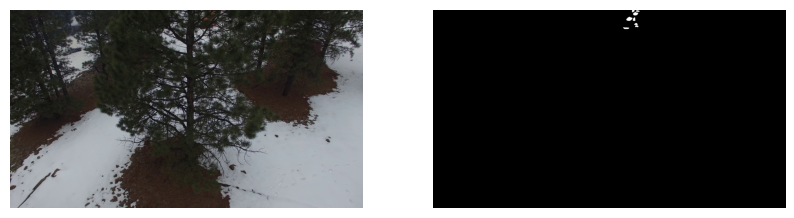

In [ ]:
img, mask = dataset[0]
show(img, mask)

## Dataset With Transforms

- see `DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()`

```
SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
```

In [ ]:
class TransformedFlameSegDataset(BaseFlameSegDataset):
    def __init__(self, image_dir, mask_dir):
        super().__init__(image_dir, mask_dir)

        self.image_transform = transforms.Compose([
            transforms.Resize(520, antialias=True),
            transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]
            )
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize(520, antialias=True)
        ])
 

    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)

        return self.image_transform(image), self.mask_transform(mask)

In [ ]:
dataset = TransformedFlameSegDataset(IMAGE_DIR, MASK_DIR)

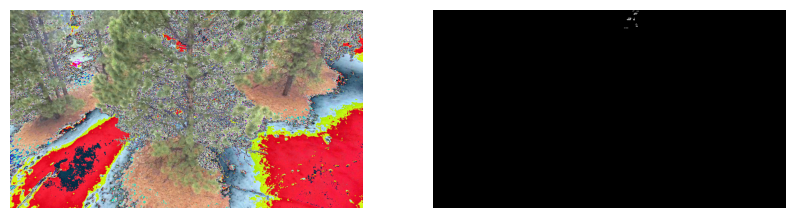

In [ ]:
img, mask = dataset[0]
show(img, mask)


## Dataloader

In [ ]:
BATCH_SIZE = 16
TRAIN_FRAC = 0.8

train, test = random_split(dataset, [TRAIN_FRAC, 1-TRAIN_FRAC], torch.Generator().manual_seed(10))

train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print("Train Size:", len(train))
print("Test Size:", len(test))

Train Size: 1603
Test Size: 400


## deeplabv3_resnet50

In [ ]:
class deeplabv3_resnet50_FLAME(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
        self.model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.model(x)

In [ ]:
model = deeplabv3_resnet50_FLAME().to(device)

## Training

In [ ]:
def plot_hist(train_loss):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [ ]:
def train(model, dl, criterion, optim, epochs=2):
    train_loss = []

    for epoch in range(epochs):
        model.train()

        batch_loss = []
        progress_bar = Progbar(len(dl))

        for i, (x, y) in enumerate(dl):
            out = model(x)
            mask = out["out"]
            aux = out["aux"]

            loss1 = criterion(y, mask)
            loss2 = criterion(y, aux)

            loss = loss1 + loss2

            batch_loss.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

            progress_bar.update(i+1, [
                ("Epoch", epoch+1),
                ("Train Loss", loss.item()),
            ])

        epoch_loss = np.mean(np.array(batch_loss))
        train_loss.append(epoch_loss)

    return train_loss

In [ ]:
lr = 1e-3

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [24]:
hist = train(model, train_dl, criterion, optimizer, epochs=5)

101/101 [==============================] - 601s 6s/step - Epoch: 5.0000 - Train Loss: 0.0104


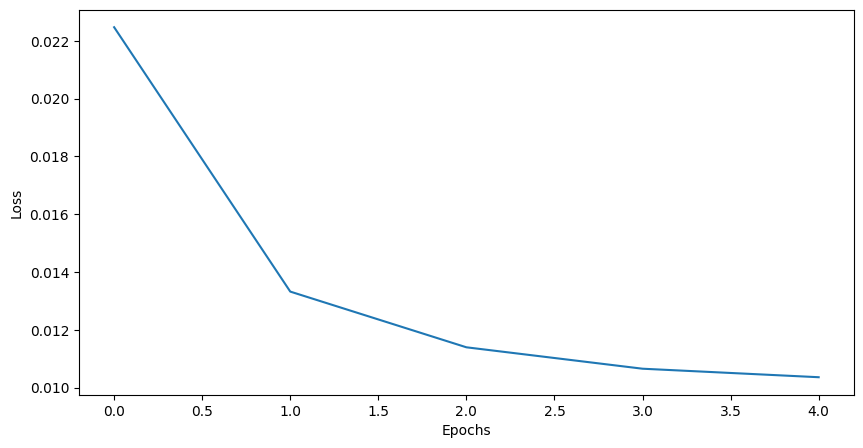

In [26]:
plot_hist(hist)

Create Checkpoint

In [27]:
EPOCH = 5
PATH = "deeplabv3_resnet50_FLAME.pt"
LOSS = 0.0104

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

## Evaluation

In [38]:
model.eval()
img, mask = dataset[100]
out = model(img.unsqueeze(0))

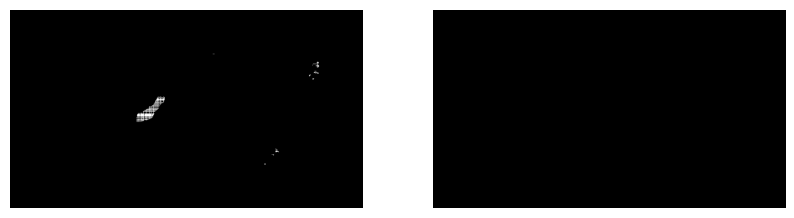

In [40]:
    show(mask, torch.round(out["out"].squeeze(dim=0)))